In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import pathlib
import shutil
import tempfile

logdir = pathlib.Path(tempfile.mkdtemp()) / "tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [7]:
ds = tf.keras.utils.get_file("HIGGS.csv.gz", 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 473s 0us/step


In [36]:
# keras can unpack gz file without decompressing them
FEATURES = 28
# This csv class returns a list of scalars for each record, so we need a function to repack that into a array
ds_u = tf.data.experimental.CsvDataset(ds, [float(),] * (FEATURES + 1), compression_type="GZIP")
def repack(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label
# Tensorflow works efficiently in batches so do a batch map
packed_ds = ds_u.batch(10000).map(repack).unbatch()

tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


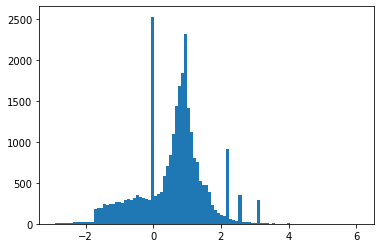

In [37]:
# Explore
for features, label in packed_ds.batch(1000).take(1):
    print(label[0])
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [38]:
# To speed things up only use 1000 val and 10000 train samples
n_val = int(1000)
n_train = int(10000)
buffer_size = int(10000)
batch_size = int(500)
step_per_epoch = n_train // batch_size

# We can use dataset.skip and dataset.take to grab the right amount of data and then use dataset.cache to load it to RAM
val_ds = packed_ds.take(n_val).cache()
train_ds = packed_ds.skip(n_val).take(n_train).cache()

val_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [39]:
# We need to batch this up and shuffle/repeat it
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.shuffle(buffer_size).repeat().batch(batch_size)

In [40]:
train_ds.take(1)

<TakeDataset shapes: ((None, 28), (None,)), types: (tf.float32, tf.float32)>

# Demonstrate Overfitting


The easiest way to prevent overfitting is to have a small model e.g. not many learnable params.

Neural Nets param size if defined by the no of layers and no of nodes per layer. Lots of params = lots of memory therefore will easily fit to the training data but wont be generalised. Too few params and the mdoel will struggle ot fit anything

Strike a balance by experimenting with structures until validation loss begins to have diminishing returns

In [41]:
# Models often perofrm better if you iteratively reduce the learning rate, use optimizers.schedules to do this
lr_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=(step_per_epoch*1000),
    decay_rate=1,
    staircase=False
)

def get_optimiser():
    return tf.keras.optimizers.Adam(lr_decay)

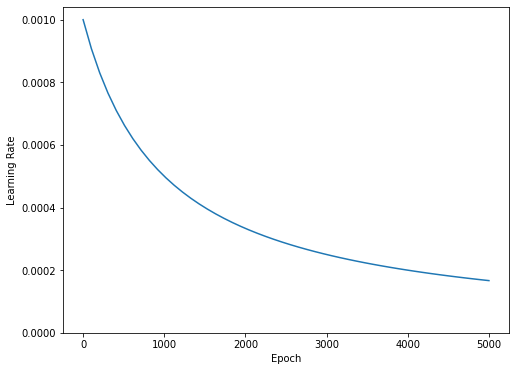

In [42]:
step = np.linspace(0, 100000)
lr = lr_decay(step)
plt.figure(figsize = (8,6))
plt.plot(step/step_per_epoch, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [47]:
# The obove will hyperbolically decrese the learning rate every 1000 epochs (1/2 at 2000, 1/3 at 3000 etc)
# We will use this optimisation in all the models so make it reusable with callbacks
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(), # <= prints full logs every 100 epochs and . for the rest
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), # <= moitors the given metric for the poin t at which it gives dimisinishing returns and then stops the training, prevents long training times
        tf.keras.callbacks.TensorBoard(logdir/name), # <= passes callbacks to TensorBoard for analysing metrics
    ]

# Each model will also use the same model.compile and model.fit settings so generalise this too
def compile_and_fit(model, name, optimiser=None, max_epochs=10000):
    
    if optimiser is None:
        optimiser = get_optimiser()
    
    model.compile(optimizer=optimiser,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy'])
    
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = step_per_epoch,
        epochs=max_epochs,
        validation_data=val_ds,
        callbacks=get_callbacks(name),
        verbose=0)
    
    return history

### Tiny Model

In [48]:
tiny_model = tf.keras.Sequential([
    # Input shape is only requires so that summary works
    # My thingy was failing because i'd reassigned to features after assigning its shape, had to change to all caps
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

model_histories = {}

model_histories['tiny'] = compile_and_fit(tiny_model, 'sizes/tiny')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch: 0, accuracy:0.4982,  binary_crossentropy:0.7322,  loss:0.7322,  val_accuracy:0.4780,  val_binary_crossentropy:0.7128,  val_loss:0.7128,  
....................................................................................................
Epoch: 100, accuracy:0.5919,  binary_crossentropy:0.6291,  loss:0.6291,  val_accuracy:0.5710,  val_binary_crossentropy:0.6313,  val_loss:0.6313,  
....................................................

....................................................................................................
Epoch: 2900, accuracy:0.6851,  binary_crossentropy:0.5689,  loss:0.5689,  val_accuracy:0.6520,  val_binary_crossentropy:0.5951,  val_loss:0.5951,  
....................................................................................................
Epoch: 3000, accuracy:0.6853,  binary_crossentropy:0.5678,  loss:0.5678,  val_accuracy:0.6640,  val_binary_crossentropy:0.5941,  val_loss:0.5941,  
......................................

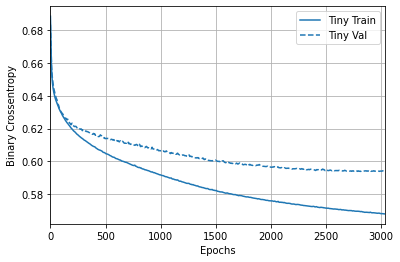

In [49]:
# Check performance
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy', smoothing_std=10)
plotter.plot(model_histories)

### Train a small/med/large model to show the effects of over/underfitting


In [58]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

med_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

model_histories['small'] = compile_and_fit(small_model, 'sizes/small')

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_39 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4848,  binary_crossentropy:0.7761,  loss:0.7761,  val_accuracy:0.4650,  val_binary_crossentropy:0.7369,  val_loss:0.7369,  
....................................................................................................
Epoch: 100, accuracy:0.6227,  binary_crossentropy:0.6155,  loss:0.6155,  val_accuracy:0.6000,  val_binary_crossentropy:0.6228,  val_loss:0

In [59]:
model_histories['medium'] = compile_and_fit(med_model, 'sizes/medium')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4877,  binary_crossentropy:0.6908,  loss:0.6908,  val_accuracy:0.4800,  val_binary_crossentropy:0.6853,  val_loss:0.6853,  
....................................................................................................


In [60]:
model_histories['large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_46 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_47 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5001,  binary_crossentropy:0.8047,  loss:0.8047,  val_accuracy:0.4780,  val_binary_crossent

### Compare the different model losses

Text(0.5, 0, 'Epochs[Log Scale]')

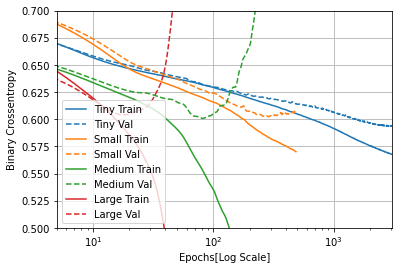

In [61]:
plotter.plot(model_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel('Epochs[Log Scale]')

We can see from the plot above that all the models, except for the tiny model, have ended up with overfitting.

This is shown by the fact the validation loss increases and diverges from the training loss.

If the training and validation loss are following the same trend, with a slight difference, then this is good.

Once the validation loss starts to plateau or increse then you have reached an overfitting condition.

It looks like ven the tiny model has begiun to overfit near the end of the epochs

NOTE: THE callbacks.EarlyStopping is what caused the training to stop when the validation loss deviated

## Methods for preventing overfitting

In [64]:
# Copy logs from tiny model to use as baseline comparison --> I think this might just be for the TensorBoard callback which we can probably ignore
shutil.rmtree(logdir/'regulisers/tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/tiny', logdir/'regulisers/tiny')

PosixPath('/var/folders/7b/zsbfny011b9c61dfgzcwrk0c0000gn/T/tmpyxyqkrrk/tensorboard_logs/regulisers/tiny')

In [65]:
reg_hists = {}
reg_hists['tiny'] = model_histories['tiny']

Regularisation:

To prevent over fitting we can put contraints on the weights f the parameters and penalise them for getting to large, thus keeping the model general becaus eit doesn't apply too much emphasis to specific features.

Common regularisation methods:

L1 = A cost function proportional to the weight is added, this drives weights to 0 and can make the model sparse

L2 = A cost function proportional to the weights squared is used, this punishes large co-efficients but allows small co-efficients, therefor doesn't drive to 0 and stops it becoming sparse == V COMMON

We pass regularisers as layer keyword arguments

In [66]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

reg_hists['l2'] = compile_and_fit(l2_model, 'regulisers/l2')

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5079,  binary_crossentropy:0.7885,  loss:2.2967,  val_accuracy:0.5500,  val_binary_crossent

l2(0.001) means the every co-effiecient in the weight matrix of the layer will add 0.001 * weight_coeff_val^2 to the total loss of the network, this why we are monitoring the binary_crossentropy as this doesn't contain the regularisation component

(0.5, 0.7)

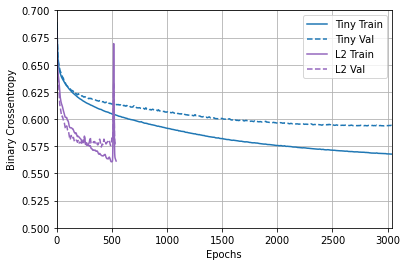

In [67]:
plotter.plot(reg_hists)
plt.ylim([0.5, 0.7])

The regularised model now performs comparatively with the tiny model in a much small number of iterations.

### Dropout Regularisation
Randomly sets weights in layers to 0, this is because in theory every node should be independent and output features which are relevant and dont depend on another node.

In train we randomly drop out 02-0.5 nodes per layer.

During test we don't drop any nodes, we just scale them all down by the dropout value

In [70]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

reg_hists['dropout'] = compile_and_fit(dropout_model, 'regulariser/dropout')


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 512)             

(0.5, 0.7)

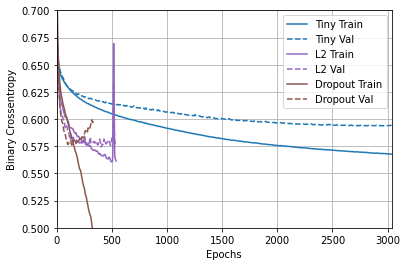

In [71]:
plotter.plot(reg_hists)
plt.ylim([0.5, 0.7])

CAn see similar comparative behaviour but its still not great, try combining the two methods?

In [72]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

reg_hists['combined'] = compile_and_fit(combined_model, 'regularisers/combined')

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 512)             

(0.5, 0.7)

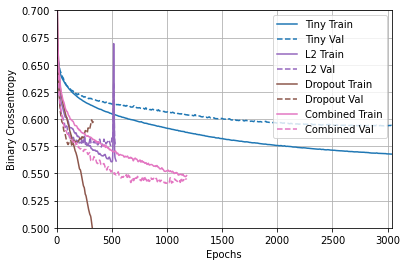

In [73]:
plotter.plot(reg_hists)
plt.ylim([0.5, 0.7])

We can see that the combined model works best!

Important things not covered: 

Batch Normalisation - https://www.tensorflow.org/addons/tutorials/layers_normalizations

Data Augmentation - https://www.tensorflow.org/tutorials/images/data_augmentation